In [14]:
import os
import sys
sys.path.append(".")
sys.path.append("..\\..")
from src.misc import getRealPath
import time
import re
import numpy as np
from src.misc import flattenList
from src.preprocessing import labelEncoder, padSequenceList, padSequence
from src.normalization import cleanJsonEvent
from src.constants import SPEAKEASY_SUBFILTER_MINIMALISTIC

from nltk.tokenize import WhitespaceTokenizer
from collections import Counter
from copy import deepcopy

STOPWORDS = flattenList([SPEAKEASY_SUBFILTER_MINIMALISTIC[x] for x in SPEAKEASY_SUBFILTER_MINIMALISTIC])

NOTEBOOK_PATH = getRealPath(type="notebook")
ROOT = NOTEBOOK_PATH + r"\..\.."
TRAINSET = ROOT + r"\data\data_filtered\speakeasy_trainset"
subFolders = [x for x in os.listdir(TRAINSET) if x.startswith("report_")]
benignFolders = ["report_clean", "report_windows_syswow64"]

LIMIT = 100 # None

VOCAB_SIZE = 10000
MAX_SEQ_LEN = 2048

tokenizer = WhitespaceTokenizer()

tick1 = time.time()
print(f"Reading and cleaning {len(subFolders)} subfolders from {TRAINSET}", end="")
jsonEventsTokenList = []
y = []
fileNames = []
for subFolder in subFolders:
    print()
    fullPath = f"{TRAINSET}\\{subFolder}"
    files = [f"{fullPath}\\{x}" for x in os.listdir(fullPath) if x.endswith(".json")]
    l = len(files)
    for i,file in enumerate(files):
        print(f"{subFolder:>20}: {i+1}/{l} {' '*30}", end="\r")
        with open(file, "r") as f:
            jsonEvent = f.read()

        jsonEventClean = cleanJsonEvent(jsonEvent)
        jsonEventTokens = tokenizer.tokenize(jsonEventClean)
        jsonEventsTokenList.append(jsonEventTokens)

        fileNames.append(file)
        if subFolder in benignFolders:
            y.append(1)
        else:
            y.append(0)
        
        if LIMIT and i == LIMIT:
            break
tick2 = time.time()
print(f"[!] Reading and cleaning took {tick2-tick1:.2f} seconds", " "*20)

print(f"[!] Building vocabulary...", end=" : ")
counter = Counter()
for jsonEventTokens in jsonEventsTokenList:
    counter.update(jsonEventTokens)
vocab = {x[0]:i for i,x in enumerate(counter.most_common(VOCAB_SIZE))}
vocab.update({"<unk>":VOCAB_SIZE, "<pad>":VOCAB_SIZE+1})
tick3 = time.time()
print(f"Took {tick3-tick2:.2f} seconds")

print(f"[!] Encoding {len(jsonEventsTokenList)} events...", end=" : ")
jsonEventsTokensEncoded = labelEncoder(jsonEventsTokenList, vocab)
tick4 = time.time()
print(f"Took {tick4-tick3:.2f} seconds")

print(f"[!] Padding {len(jsonEventsTokenList)} events...", end=" : ")
# when copy=False, pads jsonEventsTokensEncoded in place, but is faster
jsonEventsTokensEncodedPadded = padSequenceList(deepcopy(jsonEventsTokensEncoded), MAX_SEQ_LEN, vocab["<pad>"])
tick5 = time.time()
print(f"Took {tick5-tick4:.2f} seconds")

Reading and cleaning 9 subfolders from C:\Users\dtrizna\Code\nebula\modeling\tests\..\..\data\data_filtered\speakeasy_trainset
     report_backdoor: 101/11062                               
        report_clean: 101/25291                               
    report_coinminer: 101/6893                               
      report_dropper: 101/11150                               
    report_keylogger: 101/4574                               
   report_ransomware: 101/9627                               
          report_rat: 101/9479                               
       report_trojan: 101/12780                               
[!] Reading and cleaning took 6.02 seconds                     
[!] Building vocabulary... : Took 0.06 seconds
[!] Encoding 909 events... : Took 0.05 seconds
[!] Padding 909 events... : Took 0.26 seconds


## Vocabulary

3000:
> [!] Building vocabulary... : Took 0.40 seconds  
> [!] Encoding 8308 events... : Took 0.40 seconds  
> [!] Padding 8308 events... : Took 0.12 seconds

10000:
> [!] Building vocabulary... : Took 0.40 seconds  
> [!] Encoding 8308 events... : Took 0.39 seconds  
> [!] Padding 8308 events... : Took 0.13 seconds

32000:
> [!] Building vocabulary... : Took 0.54 seconds  
> [!] Encoding 8308 events... : Took 0.40 seconds  
> [!] Padding 8308 events... : Took 0.11 seconds

## Padding

> [!] Padding 4308 events... : Took 0.29 seconds -- with conversion to numpy array  
> [!] Padding 4308 events... : Took 0.05 seconds -- no conversion numpy array

`sys.getsizeof(jsonEventsTokensEncodedPadded)`
> 37208 when as list  
> 35291264 when as numpy array with dtype=np.int32

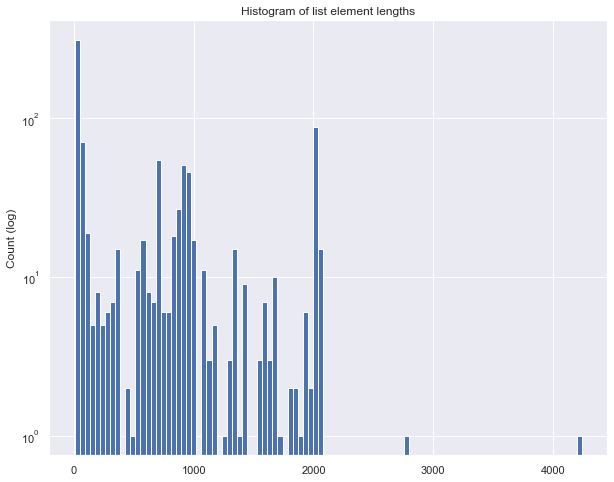

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_list_element_lengths(list_of_strings, xlim=None):
    lengths = [len(x) for x in list_of_strings]
    fix, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.hist(lengths, bins=100)
    plt.title("Histogram of list element lengths")
    plt.xlim(xlim)
    plt.yscale("log")
    plt.ylabel("Count (log)")
    plt.show()
    return lengths

_ = plot_list_element_lengths(jsonEventsTokensEncoded)#, xlim=[-10, 5000])

# attempt to biuld an analog of `trax`'s bucket by length

In [52]:
import torch
import math
import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from: https://rashmi-margani.medium.com/how-to-speed-up-the-training-of-the-sequence-model-using-bucketing-techniques-9e302b0fd976
class SequenceDataset(torch.utils.data.Dataset):
    """
    Dataset using sequence bucketing to pad each batch individually.
    
    Arguments:
        sequences (list): A list of variable length tokens (e. g. from keras tokenizer.texts_to_sequences)
        choose_length (function): A function which receives a numpy array of sequence lengths of one batch as input
                                  and returns the length this batch should be padded to.
        other_features (list, optional): A list of tensors with other features that should be fed to the NN alongside the sequences.
        labels (Tensor, optional): A tensor with labels for the samples.
        indices (np.array, optional): A numpy array consisting of indices to iterate over. 
        shuffle (bool): Whether to shuffle the dataset or not.  Default false.
        batch_size (int): Batch size of the samples. Default 512.
    """
    def __init__(self, sequences, choose_length, other_features=None, labels=None, 
                 indices=None, shuffle=False, batch_size=512):
        super(SequenceDataset, self).__init__()
        
        self.sequences = np.array(sequences)
        self.lengths = np.array([len(x) for x in sequences])
        self.n_samples = len(sequences)
        self.choose_length = choose_length
        self.other_features = other_features
        self.labels = labels
        
        if indices is not None:
            self.indices = indices
        else:
            self.indices = np.arange(len(sequences))
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        if self.shuffle:
            self._shuffle()
        
    def __len__(self):
        return math.ceil(len(self.indices) / self.batch_size)
        
    def _shuffle(self):
        self.indices = np.random.permutation(self.indices)
    
    def __getitem__(self, i):
        idx = self.indices[(self.batch_size * i):(self.batch_size * (i + 1))]
        
        if self.shuffle and i == len(self) - 1:
            self._shuffle()
        
        pad_length = math.ceil(self.choose_length(self.lengths[idx]))
        padded_sequences = pad_sequences(self.sequences[idx], maxlen=pad_length, value=VOCAB_SIZE+1)
        
        x_batch = [torch.tensor(padded_sequences, dtype=torch.long)]
        if self.other_features is not None:
            print(idx)    
            x_batch += [x[idx] for x in self.other_features]
            
        if self.labels is not None:
            out = x_batch, self.labels[idx]
        else:
            out = x_batch
    
        return out

#lengths =  [256, 512, 1024, 2048]
lengths = [len(x) for x in jsonEventsTokensEncoded]
batch_sizes = [256, 128, 64, 32]

f1 = lambda lengths: np.percentile(lengths, q=95)
f2 = lambda lengths: lengths.max()
train_dataset = SequenceDataset(jsonEventsTokensEncoded, f2, other_features=None, shuffle=False, batch_size=32)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
start_time = time.time()
for batch in train_loader:
    break

<ipython-input-52-322e8535ca74>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.sequences = np.array(sequences)


In [53]:
batch[0].shape

torch.Size([1, 32, 2050])

# y stats

In [23]:
print(len(y))
Counter(y)

8308


Counter({0: 7007, 1: 1301})

In [26]:
len(fileNames)

8308

# sizes of arrays

In [37]:
sys.getsizeof(np.array(jsonEventsTokensEncodedPadded, dtype=np.int8))/1024/1024

178.0391845703125

In [38]:
sys.getsizeof(np.array(jsonEventsTokensEncodedPadded, dtype=np.int32))/1024/1024

712.1563720703125

In [36]:
sys.getsizeof(np.array(jsonEventsTokensEncodedPadded, dtype=np.int64))/1024/1024

1424.3126220703125

In [41]:
x_train = np.array(jsonEventsTokensEncodedPadded, dtype=np.int8)
np.save(r"C:\Users\dtrizna\Code\nebula\data\data_filtered\speakeasy_trainset\x_train.npy", x_train)
y_train = np.array(y, dtype=np.int8)
np.save(r"C:\Users\dtrizna\Code\nebula\data\data_filtered\speakeasy_trainset\y_train.npy", y_train)
import pickle
with open(r"C:\Users\dtrizna\Code\nebula\data\data_filtered\speakeasy_trainset\vocab.pickle", "wb") as f:
    pickle.dump(vocab, f)
with open(r"C:\Users\dtrizna\Code\nebula\data\data_filtered\speakeasy_trainset\fileNames.pickle", "wb") as f:
    pickle.dump(fileNames, f)